# Introduction

Ali pointed out the common subset of cells favors Star Solo, as it's driving the very narrow "passed filter" set of cells. He thought it would be interesting to see how closely star solo's cells compare to cellrangers cells that passed just cell rangers filter.

In [1]:
import numpy
import pandas
import scanpy
import scipy
from matplotlib import pyplot
from pathlib import Path

from common import (
    scanpy_load_alevin_mtx,
    scanpy_load_solo_mtx,
    scanpy_load_kallisto_gene_mtx,
    compute_spearman_anndata,
    load_barcode_list,
)

In [2]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


In [3]:
def sum_diff(left, right):
    d = []
    for label in left.obs_names:
        d.append(
           numpy.abs(left[label].X - right[label].X).sum() 
        )
    return pandas.Series(d, index=left.obs_names)

def sum_diff_pandas(left, right):
    d = []
    for label in left.columns:
        d.append(
           numpy.abs(left[label] - right[label]).sum() 
        )
    return pandas.Series(d, index=left.columns)

In [4]:
def plot_difference_metrics(left, right, left_name, right_name):
    bins = 50
    common_names = list(set(left.obs_names).intersection(right.obs_names))
    #left_filtered = left[common_names,:]
    #right_filtered = right[common_names,:]
    #spearman = compute_spearman_anndata(left_filtered, right_filtered)
    #diff = sum_diff(left_filtered, right_filtered)

    left_filtered = left[common_names,:].to_df().T
    right_filtered = right[common_names,:].to_df().T
    spearman = compute_spearman_pandas(left_filtered, right_filtered)
    diff = sum_diff_pandas(left_filtered, right_filtered)

    f = pyplot.figure(figsize=(8, 6))
    f.suptitle(f"{left_name} $\cap$ {right_name}. {bins} bins")
    ax = f.add_subplot(1,2,1)
    diff.plot.hist(bins=bins, ax=ax)
    ax.set_title("$\sum{|a-b|}$")
    ax.set_xlabel('sum of absolute differences')
    ax = f.add_subplot(1,2,2)
    ax.set_title("Spearman ({} nan/{} barcodes)".format(
        len(spearman)-spearman.count(),
        len(spearman)
    ))
    spearman.plot.hist(bins=bins, ax=ax)
    ax.set_xlabel('Correlation')
    f.tight_layout()
    return f

In [5]:
project_dir = Path('~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/').expanduser()
genome_dir = project_dir / 'genome' / 'mm10-M21_minimal-male'
analysis_dir = project_dir / 'ENCSR874BOF_e10_5_minimal_limb'

In [6]:
cellranger_raw = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-minimal-e10_5-count-cells10000/outs/raw_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_raw.obs["counts"] = cellranger_raw.X.sum(axis=1)
cellranger_raw.obs["ngenes"] = numpy.array((cellranger_raw.X > 0).sum(axis=1))

cellranger_raw.obs_names = [x[:-2] for x in cellranger_raw.obs_names]
cellranger_raw.shape

(737280, 31635)

In [7]:
cellranger_filtered = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-minimal-e10_5-count-cells10000/outs/filtered_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_filtered.obs["counts"] = cellranger_filtered.X.sum(axis=1)
cellranger_filtered.obs["ngenes"] = numpy.array((cellranger_filtered.X > 0).sum(axis=1))

cellranger_filtered.obs_names = [x[:-2] for x in cellranger_filtered.obs_names]
cellranger_filtered.shape

(7598, 31635)

In [8]:
solo_raw = scanpy_load_solo_mtx(analysis_dir / 'star_solo', mode='raw')
solo_raw.shape

(737280, 31635)

In [9]:
solo_filtered = scanpy_load_solo_mtx(analysis_dir / 'star_solo', mode='filtered')
solo_filtered.shape

(6289, 31635)

In [10]:
kallisto_em_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto_em' / 'genecount')
filtered = analysis_dir / 'kallisto_em' / 'filtered-barcodes.txt'
kallisto_em_filtered = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto_em' / 'genecount', filtered)

In [11]:
kallisto_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto' / 'genecount')
filtered = analysis_dir / 'kallisto' / 'filtered-barcodes.txt'
kallisto_filtered = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto' / 'genecount', filtered)

In [12]:
alevin_raw = scanpy_load_alevin_mtx(analysis_dir / 'alevin', force_var_names=kallisto_em_filtered.var_names)
alevin_pass = load_barcode_list(analysis_dir / 'alevin' / 'alevin' / 'whitelist.txt')
alevin_filtered = alevin_raw[alevin_pass]

In [13]:
alevin_decoy_raw = scanpy_load_alevin_mtx(analysis_dir / 'alevin_decoy', force_var_names=kallisto_em_filtered.var_names)
alevin_decoy_pass = load_barcode_list(analysis_dir / 'alevin_decoy' / 'alevin' / 'whitelist.txt')
alevin_decoy_filtered = alevin_decoy_raw[alevin_decoy_pass]

In [14]:
 alevin_decoy_filtered

View of AnnData object with n_obs × n_vars = 5880 × 31635 
    obs: 'counts', 'ngenes'

In [15]:
kallisto_filtered.obs_names

Index(['GCTGCGATCTCCTATA', 'CTAGAGTTCACTATTC', 'TTTACTGGTAAACACA',
       'TACGGATAGGGTGTGT', 'CACTCCAGTCTAAACC', 'GCAAACTCACTCAGGC',
       'GGGATGACATACAGCT', 'AATCCAGAGTCGCCGT', 'CTAACTTCAAGTACCT',
       'GCATGATAGTCGTACT',
       ...
       'AGTAGTCCACAGACTT', 'AGTGAGGCACGGTAAG', 'CAGAATCGTTCGTTGA',
       'CTCGGAGTCAGTCAGT', 'GTTAAGCCAGATGAGC', 'CAGCTAAAGAGTACAT',
       'GTGCAGCAGCCGATTT', 'TACGGATAGTCTTGCA', 'GCAATCAAGACAGACC',
       'CACTCCATCTCCAACC'],
      dtype='object', length=7835)

# Comparisons

Ali's suggestion of seeing how well correlated all the cell ranger "pass filter" cells were in  in the full STAR Solo dataset was interesting, and since that's not symmetric, I had to do it bouth A filtered $\cap$ B all and B filtered $\cap$ A all.

While doing it though I discovered there are many, many cells where the scipy spearman calculation failed. Some documentation suggests that if your variance is low enough the spearman calculation can be unstable. So to give a different vague sense of "how equal" two cells are I tried the sum of the absolute difference between each gene.

$sum = \sum{|A_{gene} - B_{gene}|}$

If the two cells were equal, this metric would be zero. Ideally I'd normalize it, but I still think there's a good chance of a division by zero error.

The spearman histogram's plot title indicates how many cells had a NaN correlation and how many cells were in the intersection.

# Cell Ranger

## Cell ranger filtered $\cap$ STAR solo all

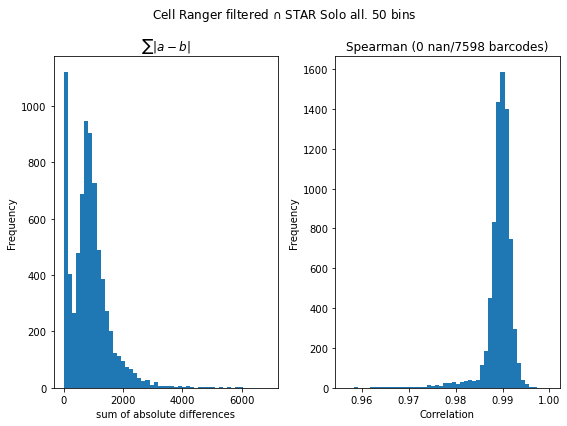

In [16]:
f = plot_difference_metrics(cellranger_filtered, solo_raw, "Cell Ranger filtered", "STAR Solo all")

## STAR Solo filtered $\cap$ Cell Ranger all

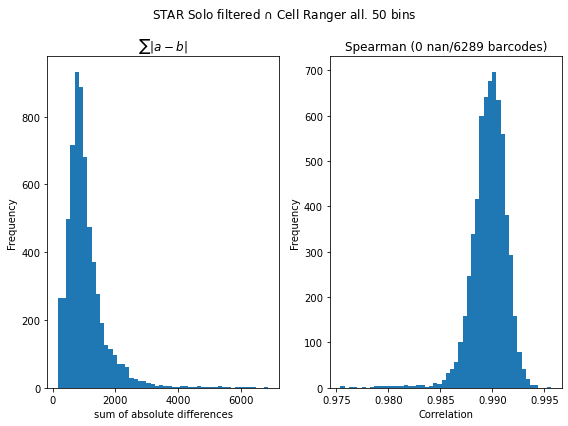

In [17]:
f = plot_difference_metrics(solo_filtered, cellranger_filtered, "STAR Solo filtered", "Cell Ranger all",)

## Cell Ranger Filtered $\cap$ Kallisto All

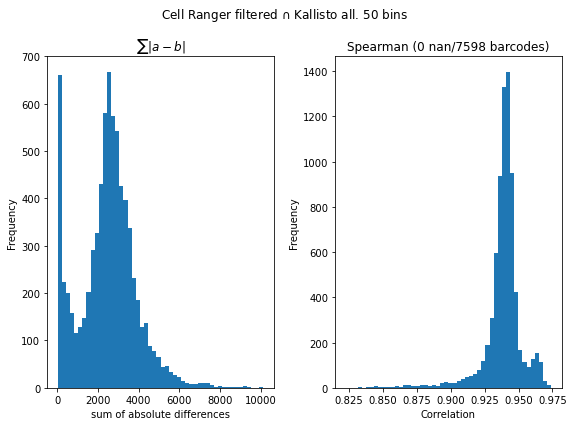

In [18]:
f = plot_difference_metrics(cellranger_filtered, kallisto_raw, "Cell Ranger filtered", "Kallisto all")

## Kallisto Filtered $\cap$ Cell Ranger All

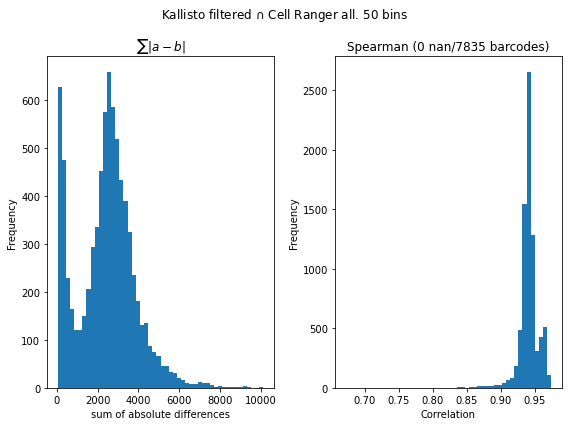

In [19]:
f = plot_difference_metrics(kallisto_filtered, cellranger_raw, "Kallisto filtered", "Cell Ranger all")

## Cell Ranger Filtered $\cap$ Kallisto EM All

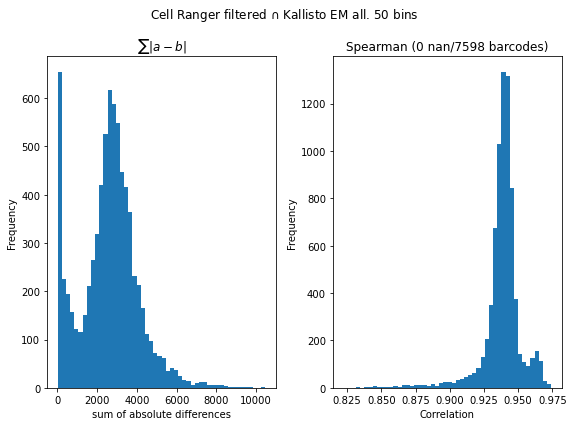

In [20]:
f = plot_difference_metrics(cellranger_filtered, kallisto_em_raw, "Cell Ranger filtered", "Kallisto EM all")

## Kallisto EM filtered $\cap$ Cell Ranger All

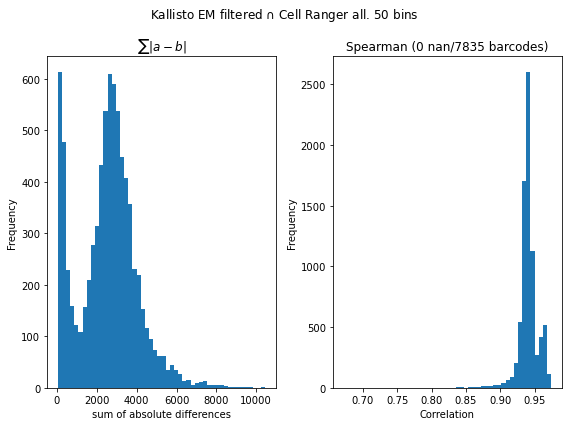

In [21]:
f = plot_difference_metrics(kallisto_em_filtered, cellranger_raw, "Kallisto EM filtered", "Cell Ranger all")

## Cell Ranger Filtered $\cap$ Alevin All

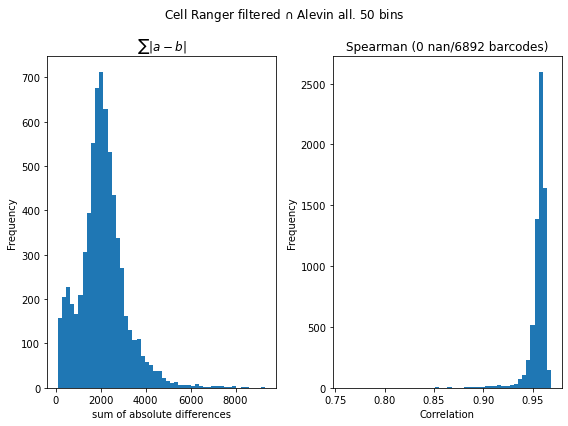

In [22]:
f = plot_difference_metrics(cellranger_filtered, alevin_raw, "Cell Ranger filtered", "Alevin all")

## Alevin filtered $\cap$ Cell Ranger All

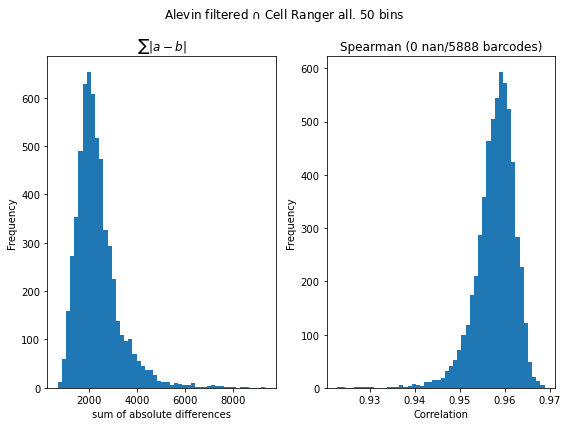

In [23]:
f = plot_difference_metrics(alevin_filtered, cellranger_raw, "Alevin filtered", "Cell Ranger all")

## Cell Ranger Filtered $\cap$ Alevin All

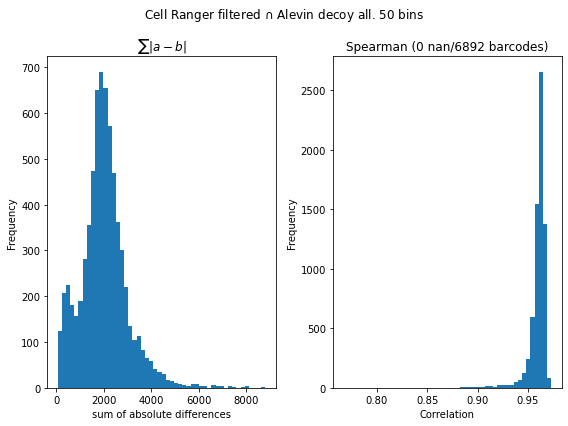

In [24]:
f = plot_difference_metrics(cellranger_filtered, alevin_decoy_raw, "Cell Ranger filtered", "Alevin decoy all")

## Alevin decoy filtered $\cap$ Cell Ranger All

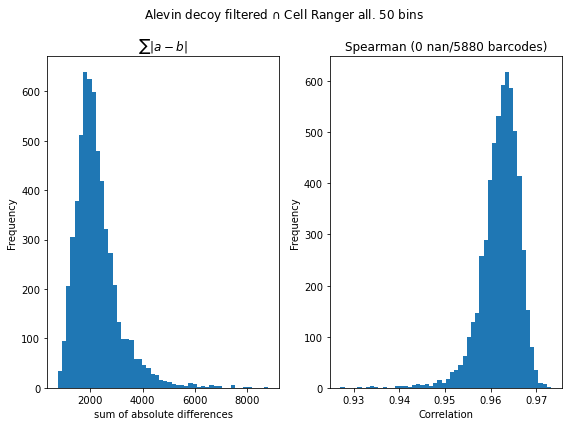

In [25]:
f = plot_difference_metrics(alevin_decoy_filtered, cellranger_raw, "Alevin decoy filtered", "Cell Ranger all")

## Cell Ranger filtered vs Alevin Decoy All

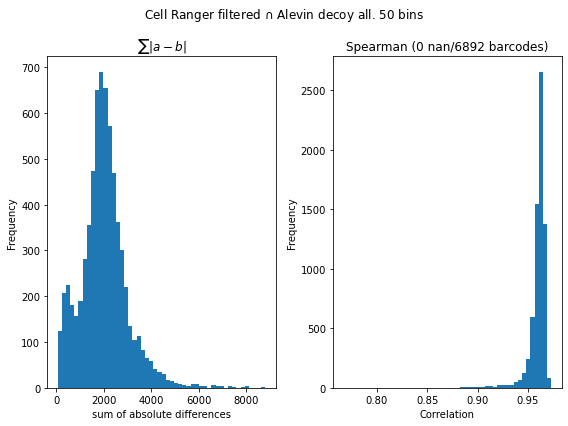

In [26]:
f = plot_difference_metrics(cellranger_filtered, alevin_decoy_raw, "Cell Ranger filtered", "Alevin decoy all")

# STAR Solo

## STAR Solo filtered $\cap$ Kallisto All

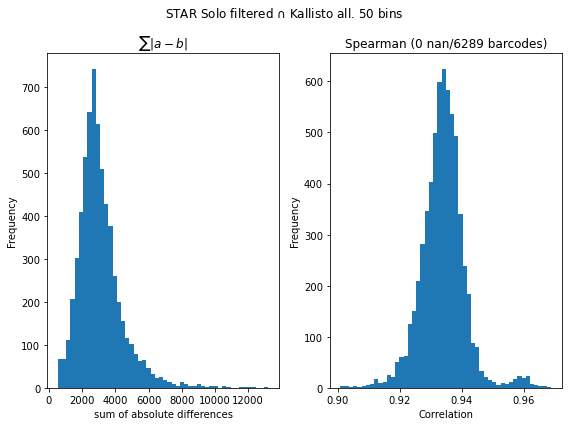

In [27]:
f = plot_difference_metrics(solo_filtered, kallisto_raw, "STAR Solo filtered", "Kallisto all")

## Kallisto filtered $\cap$ STAR Solo all

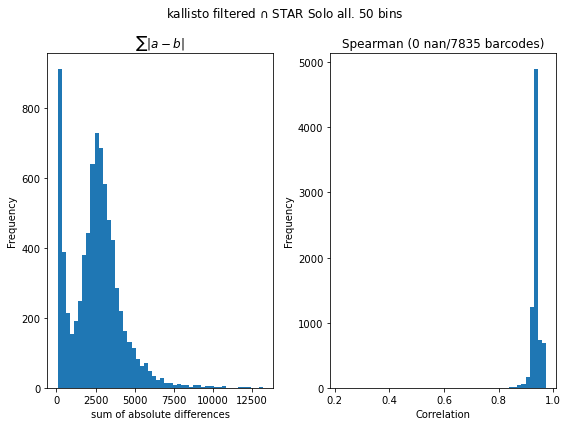

In [28]:
f = plot_difference_metrics(kallisto_filtered, solo_raw, "kallisto filtered", "STAR Solo all")

## STAR Solo Filtered $\cap$ Kallisto EM All

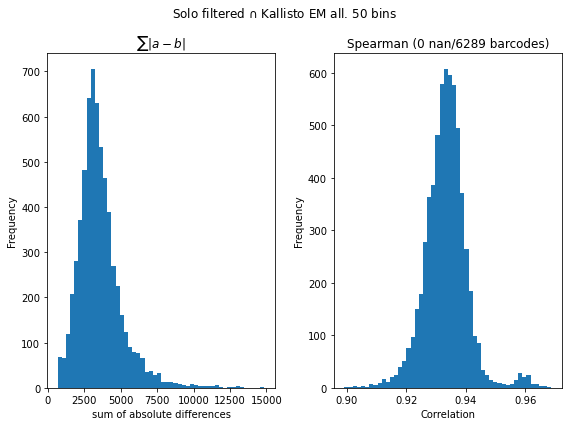

In [29]:
f = plot_difference_metrics(solo_filtered, kallisto_em_raw, "Solo filtered", "Kallisto EM all")

## Kallisto EM filtered $\cap$ STAR Solo All

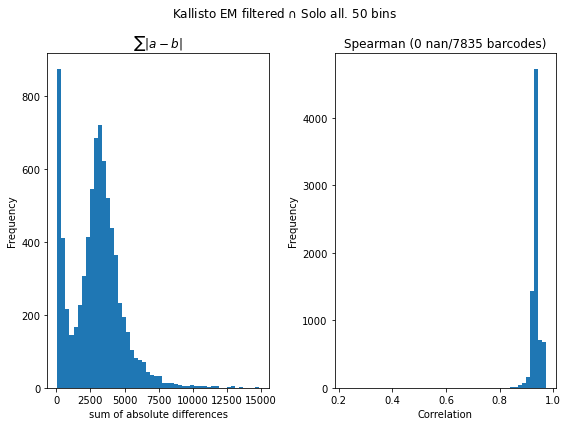

In [30]:
f = plot_difference_metrics(kallisto_em_filtered, solo_raw, "Kallisto EM filtered", "Solo all")

## Star Solo filtered $\cap$ Alevin All

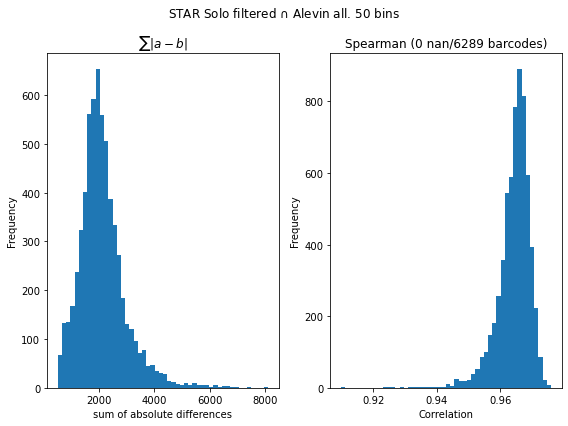

In [31]:
f = plot_difference_metrics(solo_filtered, alevin_raw, "STAR Solo filtered", "Alevin all")

## Alevin filtered $\cap$ Star Solo All

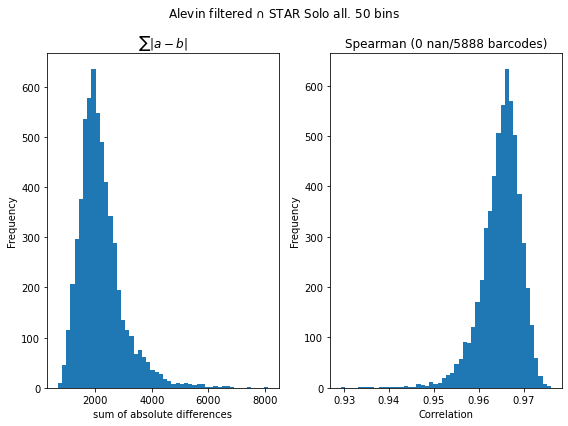

In [32]:
f = plot_difference_metrics(alevin_filtered, solo_raw, "Alevin filtered", "STAR Solo all")

## Star Solo filtered $\cap$ Alevin Decoy All

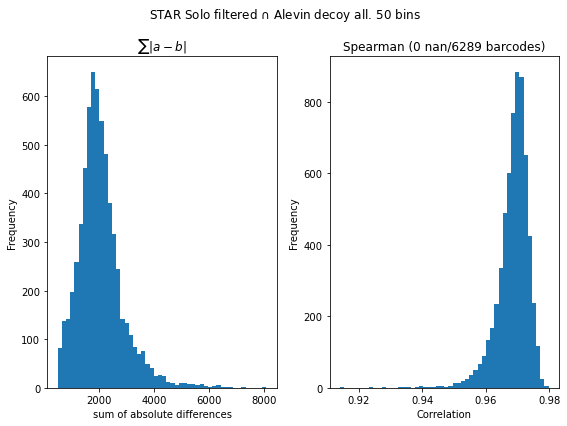

In [33]:
f = plot_difference_metrics(solo_filtered, alevin_decoy_raw, "STAR Solo filtered", "Alevin decoy all")

## Alevin Decoy Filtered $\cap$ Star Solo All

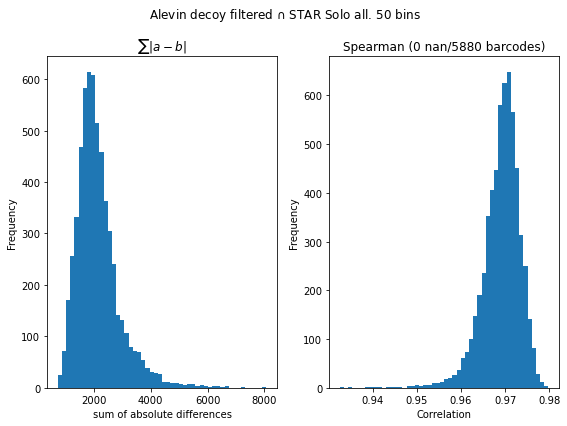

In [34]:
f = plot_difference_metrics(alevin_decoy_filtered, solo_raw, "Alevin decoy filtered", "STAR Solo all")

# Kallisto

## Kallisto filtered $\cap$ Kallisto EM All

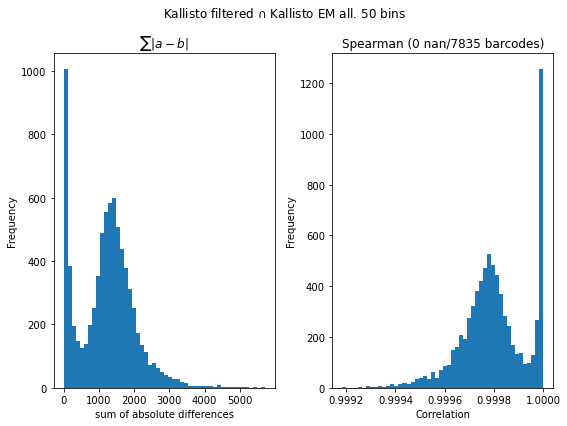

In [35]:
f = plot_difference_metrics(kallisto_filtered, kallisto_em_raw, "Kallisto filtered", "Kallisto EM all")

## Kallisto EM filtered $\cap$ Kallisto All

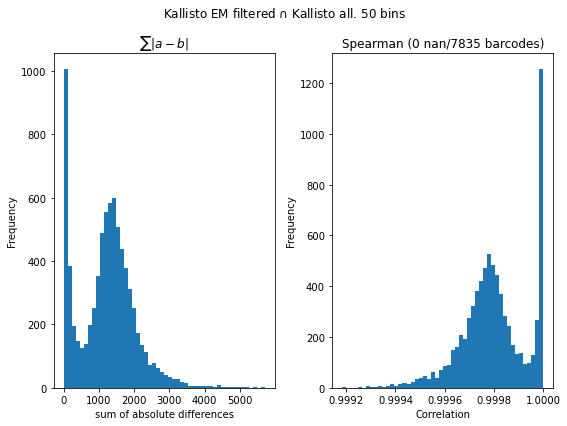

In [36]:
f = plot_difference_metrics(kallisto_em_filtered, kallisto_raw, "Kallisto EM filtered", "Kallisto all")

## Kallisto filtered $\cap$ Alevin all

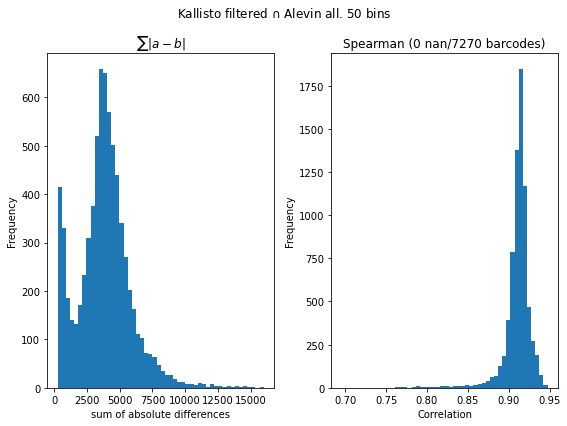

In [37]:
f = plot_difference_metrics(kallisto_filtered, alevin_raw, "Kallisto filtered", "Alevin all")

## Alevin filtered $\cap$ Kallisto All

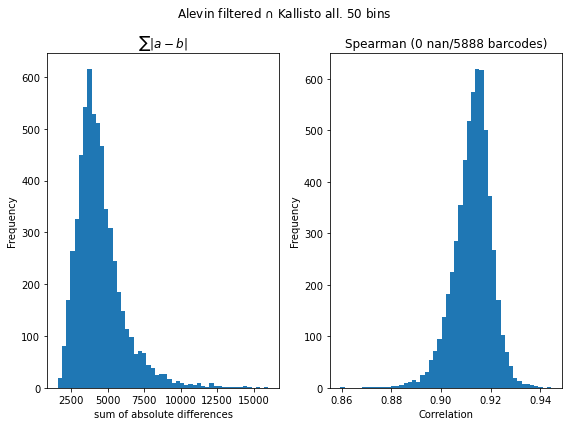

In [38]:
f = plot_difference_metrics(alevin_filtered, kallisto_raw, "Alevin filtered", "Kallisto all")

## Kalisto filtered $\cap$ Alevin Decoy All

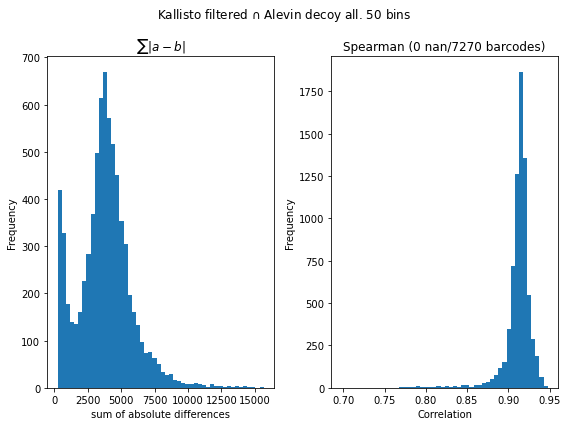

In [39]:
f = plot_difference_metrics(kallisto_filtered, alevin_decoy_raw, "Kallisto filtered", "Alevin decoy all")

## Alevin decoy filtered $\cap$ Kallisto All

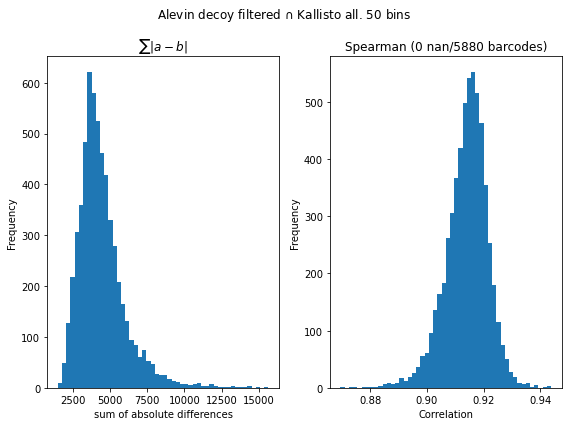

In [40]:
f = plot_difference_metrics(alevin_decoy_filtered, kallisto_raw, "Alevin decoy filtered", "Kallisto all")

# Kallisto EM

## Kallisto EM filtered $\cap$ Alevin All

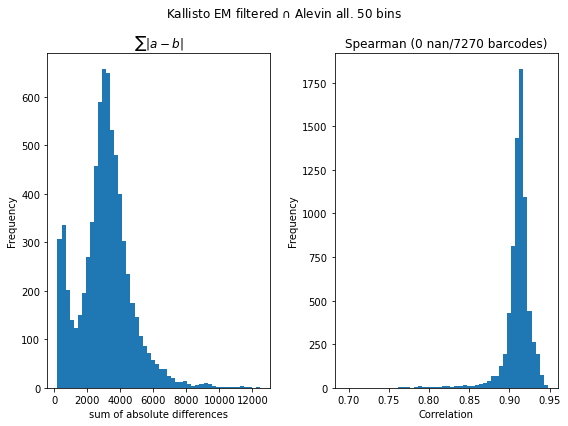

In [41]:
f = plot_difference_metrics(kallisto_em_filtered, alevin_raw, "Kallisto EM filtered", "Alevin all")

## Alevin filtered $\cap$ Kallisto EM all

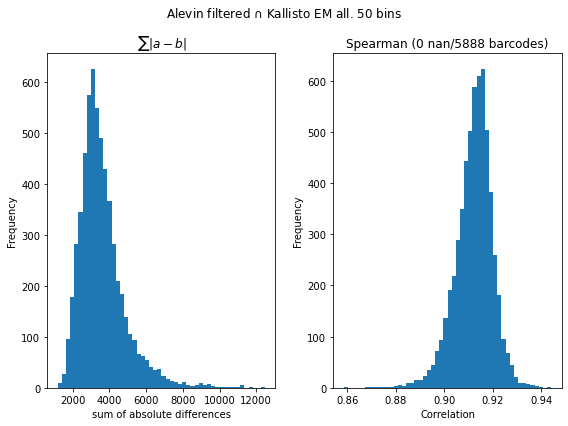

In [42]:
f = plot_difference_metrics(alevin_filtered, kallisto_em_raw, "Alevin filtered", "Kallisto EM all")

## Kallisto EM filtered Alevin decoy all

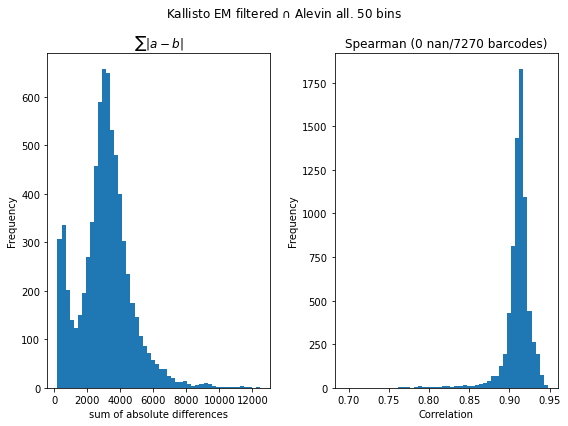

In [43]:
f = plot_difference_metrics(kallisto_em_filtered, alevin_raw, "Kallisto EM filtered", "Alevin all")

## Alevin decoy all $\cap$ Kallisto EM all

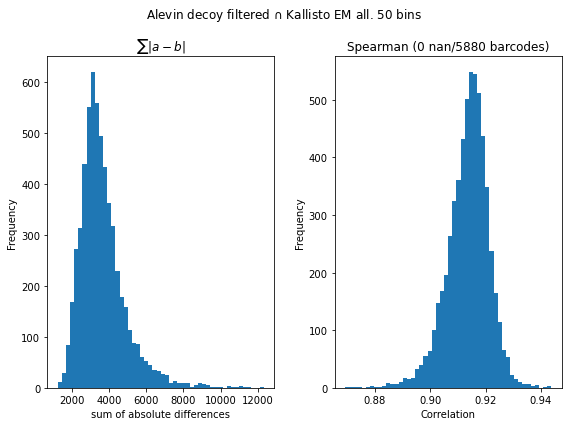

In [44]:
f = plot_difference_metrics(alevin_decoy_filtered, kallisto_em_raw, "Alevin decoy filtered", "Kallisto EM all")

# Alevin

## Alevin filtered $\cap$ Alevin decoy all

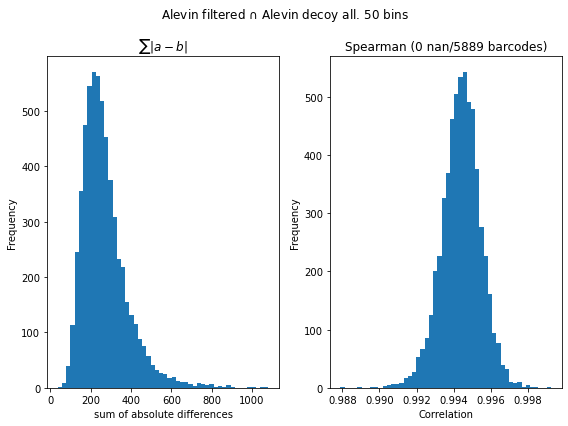

In [45]:
f = plot_difference_metrics(alevin_filtered, alevin_decoy_raw, "Alevin filtered", "Alevin decoy all")

## Alevin decoy Filtered $\cap$ Alevin All

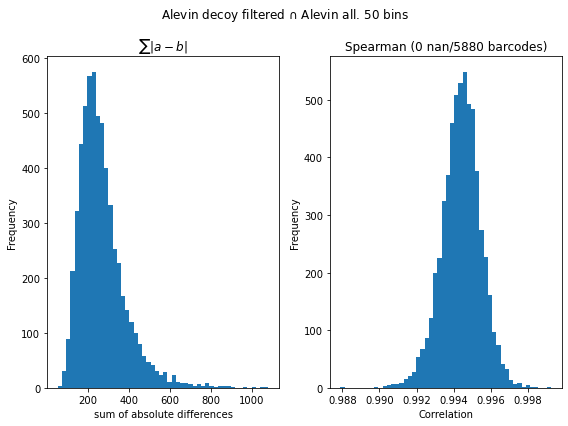

In [46]:
f = plot_difference_metrics(alevin_decoy_filtered, alevin_raw, "Alevin decoy filtered", "Alevin all")

In [47]:
cellranger_filtered[label].X

NameError: name 'label' is not defined

In [ ]:
for label in cellranger_filtered.obs_names:
    if pandas.isnull(scipy.stats.spearmanr(cellranger_filtered[label].X.todense(), solo_raw[label].X.todense())[0]):
        print(label, cellranger_filtered[label].X.sum(), solo_raw[label].X.sum())
        break

In [ ]:
scipy.stats.spearmanr(cellranger_filtered[label].X.todense(), solo_raw[label].X.todense())